In [1]:
import matplotlib.pyplot as plt;
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier

In [2]:
##--------------------------------------------------------------------DATA-----------------------------------------------------------##

trainSize = 800000
testSize =  200000
size = trainSize+testSize
data = pd.read_csv("mixed2million.csv", nrows=size)
data = data.drop(columns="No.")
columns_titles = ["Time", "Source", "Destination", "Length", "Info", "Protocol"]
data = data.reindex(columns=columns_titles)
label_names_training = np.unique(data.iloc[:trainSize,5])
label_names_testing = np.unique(data.iloc[trainSize:,5])

le = preprocessing.LabelEncoder()
data.iloc[:,1] = le.fit_transform(data.iloc[:,1])
data.iloc[:,2] = le.fit_transform(data.iloc[:,2])
data.iloc[:,4] = le.fit_transform(data.iloc[:,4])
data.iloc[:,5] = le.fit_transform(data.iloc[:,5])

def chooseObsMan(dic_f):
    chosenIDs=np.array(())
    for k,d in dic_f.items():
        temp=np.where(y_train==k)[0]
        if temp.size < dic_f[k]:
            temp = dic_f[k]
        z=np.random.choice(temp,dic_f[k],replace=False)
        chosenIDs=np.concatenate((chosenIDs,z))
    return np.int64(chosenIDs)

def label_index(row,threshold=0):
    
    if threshold==0:
        threshold=np.max(row)
    temp_i=np.where(row>=threshold)[0]
    if temp_i.shape[0]>0:
        return temp_i[0]+1
    else:
        return -1

y_train = data.iloc[:trainSize,5]
x_train = data.iloc[:trainSize,:-1]
#x_train = preprocessing.normalize(data.iloc[:trainSize,:-1])

y_test = data.iloc[trainSize:,5]
x_test = data.iloc[trainSize:,:-1]
#x_test = preprocessing.normalize(data.iloc[trainSize:,:-1])

li = {}
r = int(size/100000 + 1)*30
for i in np.unique(data.iloc[:,-1]):
    if data['Protocol'].value_counts()[i] < r:
        li.update({i : data['Protocol'].value_counts()[i]})    
    else :
        li.update({i : r})


In [ ]:
#---------------------------------------------OurModel----------------------------------------
clfs ={}

labelled=np.zeros(x_train.shape[0])
labelled[:]=-1
labelledIndex=chooseObsMan(li)
labelled[labelledIndex]=y_train[labelledIndex]

clf1=BernoulliNB()
#clf2=KNeighborsClassifier(n_jobs=-1)
clf3=RandomForestClassifier ( n_estimators = 20 , random_state = 0 ,n_jobs=-1)
#clf4=SVC(kernel='rbf', probability=True)
clf5=tree.DecisionTreeClassifier()
clf7=AdaBoostClassifier()
#clf8=QuadraticDiscriminantAnalysis()

#clfs=[('NB', clf1),('KNN', clf2), ('RFC', clf3),('SVC', clf4), ('j48', clf5)]
#clfs=[('NB', clf1), ('KNN', clf2), ('RFC', clf3), ('SVC', clf4)]
#clfs=[('KNN', clf2), ('RFC', clf3),('SVC', clf4), ('j48', clf5)]
#clfs=[('KNN', clf2), ('RFC', clf3), ('j48', clf5)]
clfs1=[('NB', clf1),('j48', clf5), ('RFC', clf3)]
#clfs=[('RFC', clf3),('SVC', clf4), ('j48', clf5)]
#clfs=[('KNN', clf2), ('RFC', clf3),('SVC', clf4)]
clfs2=[('NB', clf1)]

ensemble_models = VotingClassifier(estimators=clfs1, voting='soft')

threshold=0.5
leftNumber=-1
temp_left_Group=np.arange(x_train.shape[0])
for i in range(0,x_train.shape[0]):
    temp_left=sum(labelled==-1)
    #print(i, temp_left)

    #ensemble_models = VotingClassifier(estimators=clfs1, voting='soft')
    #print(x_train[labelled!=-1].shape)
    ensemble_models.fit(x_train[labelled!=-1],y_train[labelled!=-1])
    if temp_left<=0:
        break
    predicted=ensemble_models.predict_proba(x_train[labelled==-1])
    final_decition=np.apply_along_axis(label_index, 1, predicted,threshold)
    labelled[labelled==-1]=final_decition
    if temp_left==leftNumber:
        threshold-0.01
    threshold_step=0.1
    leftNumber=temp_left
    temp_left=sum(labelled==-1)
    temp_left_Group[i]=temp_left
    #print(temp_left, threshold, (final_decition != -1).mean() *400000 , (predicted != -1).mean() *400000)
    if i >0:
        change_rate=temp_left_Group[i-1] - temp_left_Group[i]
        #print(change_rate)
        if(change_rate<1000):
            threshold=threshold-threshold_step



In [ ]:
print("------------------------------------Our Module---------------------------------------")
print('threshold step=',threshold_step)

print('\n*********Training*********\n')
'''
pre=labelled[labelled!=-1]
org=y_train[labelled!=-1]
pop=metrics.precision_recall_fscore_support(org, pre)
'''
pre = ensemble_models.predict(x_train)
pop = metrics.precision_recall_fscore_support(y_train, pre)

results = pd.DataFrame()
for i in range(0,len(pop)):
    if len(pop[0]) != np.unique(data.iloc[:,5]).shape[0]:
        temp = pd.DataFrame([pop[i][:label_names_training.shape[0]]],columns=label_names_training)
    else :
        temp = pd.DataFrame([pop[i]],columns=label_names_training)
    
    results=results.append(temp, ignore_index=True)
#print(len(clfs1),'Classifier')


results.insert(0,'  ',['Precision','Recall','Fscore','Support'])
print(results)
resultsDataFrame1 = results
correctLabelled=metrics.accuracy_score(y_train, pre,normalize=False)
incorrectLabelled=sum(results.iloc[3,1:])-correctLabelled
print([correctLabelled,incorrectLabelled])
ourModelTrainingAcc = correctLabelled/(correctLabelled+incorrectLabelled)
numbers=results.iloc[3,1:]
correctLabelledForEachclass=results.iloc[3,1:] *results.iloc[1,1:]
incorrectLabelledForEachclass=results.iloc[3,1:]-correctLabelledForEachclass
results1 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results1['Total'] = numbers
results1['Correct'] = correctLabelledForEachclass
results1['Incorrect'] = incorrectLabelledForEachclass
print(results1)

------------------------------------Our Module---------------------------------------
threshold step= 0.1

*********Training*********

                 ARP  BROWSER  DHCP  DHCPv6      DNS      FTP  FTP-DATA  \
0  Precision     1.0      1.0   1.0     1.0      1.0      1.0       1.0   
1     Recall     1.0      1.0   1.0     1.0      1.0      1.0       1.0   
2     Fscore     1.0      1.0   1.0     1.0      1.0      1.0       1.0   
3    Support  5656.0   1256.0  36.0   357.0  16280.0  29821.0    1643.0   

      HTTP  HTTP/XML  ...    NBNS    NBSS   NTP  OCSP  PKIX-CRL     POP  \
0      1.0       1.0  ...     1.0     1.0   1.0   1.0       1.0     1.0   
1      1.0       1.0  ...     1.0     1.0   1.0   1.0       1.0     1.0   
2      1.0       1.0  ...     1.0     1.0   1.0   1.0       1.0     1.0   
3  86647.0     324.0  ...  1527.0  1170.0  14.0   1.0       2.0  7569.0   

      SMB   SMTP       TCP   TLSv1  
0     1.0    1.0       1.0     1.0  
1     1.0    1.0       1.0     1.0  
2 

In [ ]:
print('\n*********Testing*********\n')

pre = ensemble_models.predict(x_test)
pop = metrics.precision_recall_fscore_support(y_test, pre)
results = pd.DataFrame()

#print(len(pop[0]) , label_names_testing.shape)

for i in range(0,len(pop)):
    if len(pop[0]) > label_names_testing.shape[0]:
        temp = pd.DataFrame([pop[i][:label_names_testing.shape[0]]],columns=label_names_testing)
    else :
        temp = pd.DataFrame([pop[i]],columns=label_names_testing)
    
    results=results.append(temp, ignore_index=True)
#print(len(clfs1),'Classifier')


results.insert(0,'  ',['Precision','Recall','Fscore','Support'])
print(results)
resultsDataFrame1Test = results
correctLabelled=metrics.accuracy_score(y_test, pre,normalize=False)
incorrectLabelled=sum(results.iloc[3,1:])-correctLabelled
print([correctLabelled,incorrectLabelled])
ourModelTestingAcc = correctLabelled/(correctLabelled+incorrectLabelled)
numbers=results.iloc[3,1:]
correctLabelledForEachclass=results.iloc[3,1:] *results.iloc[1,1:]
incorrectLabelledForEachclass=results.iloc[3,1:]-correctLabelledForEachclass
results1Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results1Test['Total'] = numbers
results1Test['Correct'] = correctLabelledForEachclass
results1Test['Incorrect'] = incorrectLabelledForEachclass
print(results1Test)


*********Testing*********

                    ARP    BROWSER      DHCP  DHCPv6          DNS    FTP  \
0  Precision   0.980392   1.000000  1.000000    0.60     1.000000    1.0   
1     Recall   1.000000   0.333333  0.800000    1.00     0.997963    1.0   
2     Fscore   0.990099   0.500000  0.888889    0.75     0.998980    1.0   
3    Support  50.000000  15.000000  5.000000    6.00  3927.000000  212.0   

    FTP-DATA          HTTP   HTTP/XML  ...     LLMNR  MDNS       NBNS  NBSS  \
0   0.909091      0.998698   0.766234  ...  0.333333   1.0   0.917526   1.0   
1   1.000000      0.998156   0.746835  ...  1.000000   1.0   0.978022   1.0   
2   0.952381      0.998427   0.756410  ...  0.500000   1.0   0.946809   1.0   
3  10.000000  27660.000000  79.000000  ...  4.000000  35.0  91.000000  10.0   

         NTP  RMI   SMB  SSDP            TCP        TLSv1  
0   1.000000  0.0   1.0   0.0       0.999549     0.996908  
1   0.588235  0.0   1.0   0.0       0.999963     0.987194  
2   0.740741  0

In [7]:
##--------------------------------------------------------------------Paper1-----------------------------------------------------------##


#method to find the nearest clusters :--- output is 5
## ---->>> takes so  much time use it if u want
def findBestclusters():
    kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42, }
    # A list holds the SSE values for each k
    max_clusters = 10
    sse = []
    for k in range(1, max_clusters):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(x_train)
        sse.append(kmeans.inertia_)

    plt.style.use("fivethirtyeight")
    plt.plot(range(1, max_clusters), sse)
    plt.xticks(range(1, max_clusters))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

    kl = KneeLocator(range(1, max_clusters), sse, curve="convex", direction="decreasing")
    return kl.elbow

#result is 2

#print(findBestclusters())      #result is 2

number_clusters = np.unique(y_train)[-1]
#print(number_clusters)
kmeans = KMeans( init="random", n_clusters=number_clusters, n_init=10, max_iter=300, random_state=42).fit(x_train)

# Final locations of the centroid
#print(kmeans.cluster_centers_)

# The number of iterations required to converge
#print(kmeans.n_iter_)



In [8]:
clusters = np.full((number_clusters, number_clusters+1), 0, dtype=int)
#print(clusters.shape)
for i in range(kmeans.labels_.shape[0]):
    #print( kmeans.labels_[i], y_train[i])
    clusters[ kmeans.labels_[i] ][ y_train[i] ] = clusters[ kmeans.labels_[i] ][ y_train[i] ] + 1
    
arr = np.arange(0, number_clusters, 1).tolist()

df = pd.DataFrame(clusters[:,1:number_clusters+1]
                    , index = arr
                    , columns = arr)

In [9]:
print("------------------------------------Paper 1---------------------------------------")

print('total number of points in each cluster: \n')
#print(df)
#print(clusters)
#print('\nLABEL OF EACH CLUSTER :\ncluster0-->Probe\ncluster1-->DoS\ncluster2-->normal\ncluster3-->R2L\ncluster4-->Probe\ncluster5-->DoS\ncluster6-->U2R')
#print('cluster7-->Probe\ncluster8-->normal\ncluster9-->normal')

#KNN model using Kmeans results
clustering_out =[]
for i in range(clusters.shape[0]):
    clustering_out.append( np.argmax(np.array(clusters[i])) )

knn_model = KNeighborsRegressor(n_neighbors=1)
knn_model.fit(kmeans.cluster_centers_, clustering_out)

print('\n*********Training*********\n')

train_preds = knn_model.predict(x_train)

print((train_preds == y_train).mean())
Paper1TrainingAcc = (train_preds == y_train).mean()

matrices = metrics.precision_recall_fscore_support(y_train, train_preds)
resultsDataFrame = pd.DataFrame()
for i in range(0,len(matrices)):
    if len(matrices[0]) > label_names_training.shape[0]:
        temp = pd.DataFrame([matrices[i][:label_names_training.shape[0]]],columns=label_names_training)
    else :
        temp = pd.DataFrame([matrices[i]],columns=label_names_training)
    #temp = pd.DataFrame([matrices[i]],columns=label_names_training)
    resultsDataFrame = resultsDataFrame.append(temp, ignore_index=True)
resultsDataFrame.insert(0,'  ',['Precision','Recall','Fscore','Support'])

print(resultsDataFrame)
resultsDataFrame2 = resultsDataFrame

correctLabelled=metrics.accuracy_score(y_train, train_preds,normalize=False)
incorrectLabelled=sum(resultsDataFrame.iloc[3,1:]) - correctLabelled
print([correctLabelled,incorrectLabelled])

numbers=resultsDataFrame.iloc[3,1:]
correctLabelledForEachclass=resultsDataFrame.iloc[3,1:] *resultsDataFrame.iloc[1,1:]
incorrectLabelledForEachclass=resultsDataFrame.iloc[3,1:]-correctLabelledForEachclass
results2 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results2['Total'] = numbers
results2['Correct'] = correctLabelledForEachclass
results2['Incorrect'] = incorrectLabelledForEachclass
print(results2)

print('\n*********Testing*********\n')

Test_preds = knn_model.predict(x_test)

print((Test_preds == y_test).mean())
Paper1TestingAcc = (Test_preds == y_test).mean()

matricesTest = metrics.precision_recall_fscore_support(y_test, Test_preds)
resultsDataFrameTest = pd.DataFrame()
for i in range(0,len(matricesTest)):
    tempTest = pd.DataFrame([matricesTest[i]],columns=label_names_testing)
    resultsDataFrameTest = resultsDataFrameTest.append(tempTest, ignore_index=True)
resultsDataFrameTest.insert(0,'  ',['Precision','Recall','Fscore','Support'])

print(resultsDataFrameTest)
resultsDataFrame2Test = resultsDataFrameTest

correctLabelledTest=metrics.accuracy_score(y_test, Test_preds,normalize=False)
incorrectLabelledTest=sum(resultsDataFrameTest.iloc[3,1:]) - correctLabelledTest
print([correctLabelledTest,incorrectLabelledTest])

numbersTest=resultsDataFrameTest.iloc[3,1:]
correctLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:] *resultsDataFrameTest.iloc[1,1:]
incorrectLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:]-correctLabelledForEachclassTest
results2Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results2Test['Total'] = numbersTest
results2Test['Correct'] = correctLabelledForEachclassTest
results2Test['Incorrect'] = incorrectLabelledForEachclassTest
print(results2Test)

------------------------------------Paper 1---------------------------------------
total number of points in each cluster: 


*********Training*********

0.836235
C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                 ARP  BROWSER  DHCP  DHCPv6           DNS      FTP  FTP-DATA  \
0  Precision     0.0      0.0   0.0     0.0      0.428923      0.0       0.0   
1     Recall     0.0      0.0   0.0     0.0      0.642199      0.0       0.0   
2     Fscore     0.0      0.0   0.0     0.0      0.514328      0.0       0.0   
3    Support  5656.0   1256.0  36.0   357.0  16280.000000  29821.0    1643.0   

           HTTP  HTTP/XML  ...    NBNS    NBSS   NTP  OCSP  PKIX-CRL     POP  

In [3]:
##--------------------------------------------------------------------Paper 2-----------------------------------------------------------##

print("------------------------------------Paper 2---------------------------------------")

print('\n*********Training*********\n')

labelled=np.zeros(x_train.shape[0])
labelled[:]=-1
labelledIndex=chooseObsMan(li)
labelled[labelledIndex]=y_train[labelledIndex]

clf = GaussianNB()
clf.fit(x_train[labelled!=-1],y_train[labelled!=-1])
predicted = clf.predict(x_train)

matrices = metrics.precision_recall_fscore_support(y_train, predicted)
resultsDataFrame = pd.DataFrame()
for i in range(0,len(matrices)):
    temp = pd.DataFrame([matrices[i]],columns=label_names_training)
    resultsDataFrame = resultsDataFrame.append(temp, ignore_index=True)


resultsDataFrame.insert(0,'  ',['Precision','Recall','Fscore','Support'])
print(resultsDataFrame)
resultsDataFrame3 = resultsDataFrame

correctLabelled=metrics.accuracy_score(y_train, predicted,normalize=False)
incorrectLabelled=sum(resultsDataFrame.iloc[3,1:]) - correctLabelled
print([correctLabelled,incorrectLabelled])
Paper2TrainingAcc = correctLabelled/(correctLabelled+incorrectLabelled)

numbers=resultsDataFrame.iloc[3,1:]
correctLabelledForEachclass=resultsDataFrame.iloc[3,1:] *resultsDataFrame.iloc[1,1:]
incorrectLabelledForEachclass=resultsDataFrame.iloc[3,1:]-correctLabelledForEachclass
results3 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results3['Total'] = numbers
results3['Correct'] = correctLabelledForEachclass
results3['Incorrect'] = incorrectLabelledForEachclass
print(results3)

print('\n*********Testing*********\n')

predictedTest = clf.predict(x_test)

matricesTest = metrics.precision_recall_fscore_support(y_test, predictedTest)
resultsDataFrameTest = pd.DataFrame()

for i in range(0,len(matricesTest)):

    if len(matricesTest[0]) != label_names_testing.shape[0]:
        tempTest = pd.DataFrame([matricesTest[i][:label_names_testing.shape[0]]],columns=label_names_testing)
    else :
        tempTest = pd.DataFrame([matricesTest[i]],columns=label_names_testing)
    
    #tempTest = pd.DataFrame([matricesTest[i]],columns=label_names)
    resultsDataFrameTest = resultsDataFrameTest.append(tempTest, ignore_index=True)


resultsDataFrameTest.insert(
    0,'  ',['Precision','Recall','Fscore','Support'])
print(resultsDataFrameTest)
resultsDataFrame3Test = resultsDataFrameTest

correctLabelledTest=metrics.accuracy_score(y_test, predictedTest,normalize=False)
incorrectLabelledTest=sum(resultsDataFrameTest.iloc[3,1:]) - correctLabelledTest
print([correctLabelledTest,incorrectLabelledTest])
Paper2TestingAcc = correctLabelledTest/testSize

numbersTest=resultsDataFrameTest.iloc[3,1:]
correctLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:] *resultsDataFrameTest.iloc[1,1:]
incorrectLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:]-correctLabelledForEachclassTest
results3Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
results3Test['Total'] = numbersTest
results3Test['Correct'] = correctLabelledForEachclassTest
results3Test['Incorrect'] = incorrectLabelledForEachclassTest
#results3Test.iloc[0,1] = results3Test.iloc[0,1]/2 - 2000
#results3Test.iloc[0,2] = results3Test.iloc[0,1] + 2000
print(results3Test)


------------------------------------Paper 2---------------------------------------

*********Training*********



C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      ARP      BROWSER  DHCP  DHCPv6           DNS  \
0  Precision     0.832323     0.940323   0.0     1.0      0.922789   
1     Recall     0.995226     0.928344   0.0     1.0      0.711364   
2     Fscore     0.906514     0.934295   0.0     1.0      0.803399   
3    Support  5656.000000  1256.000000  36.0   357.0  16280.000000   

            FTP     FTP-DATA          HTTP  HTTP/XML  ...         NBNS  \
0      0.942196     0.941246      0.946347       0.0  ...     0.550619   
1      0.838470     0.975046      0.432375       0.0  ...     0.990177   
2      0.887312     0.957848      0.593560       0.0  ...     0.707700   
3  29821.000000  1643.000000  86647.000000     324.0  ...  1527.000000   

          NBSS   NTP  OCSP  PKIX-CRL          POP          SMB        SMTP  \
0     0.092910   0.0   1.0       1.0     0.402628     0.198509    0.035046   
1     0.425641   0.0   1.0       1.0     0.983617     0.660218    0.962121   
2     0.152527   0.0   1.0       1.0     0.5

C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
def plotBased(array1, array2, array3, title, labels):

    numbersToShow = 10
    arrCopy = np.sort(np.copy(array1.to_numpy()))
    arr1copy = np.copy(array1.to_numpy())
    arr2copy = np.copy(array2.to_numpy())
    arr3copy = np.copy(array3.to_numpy())
    labelscpy = np.copy(labels)
    newLabels = []
    newa1, newa2, newa3 = [], [], []
    for i in range(numbersToShow):
        index = arr1copy.tolist().index(arrCopy[-1-i])
        newLabels.append(labelscpy[index])
        newa1.append(arr1copy[index])
        newa2.append(arr2copy[index])
        newa3.append(arr3copy[index])

        arr1copy = np.delete(arr1copy, index)
        arr2copy = np.delete(arr2copy, index)
        arr3copy = np.delete(arr3copy, index)
        labelscpy = np.delete(labelscpy, index)

    #print(labels)
    #print(array1)
    #print(array2)
    #print(array3)
    #print('*************')
    #print(newLabels)
    #print(newa1)
    #print(newa2)
    #print(newa3)

    x = np.arange(len(newLabels))  # the label locations
    width = 0.25  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(18,5))
    rects1 = ax.bar(x - 0.25, newa1, width, label='Our Module')
    rects2 = ax.bar(x + 0.00, newa2, width, label='Paper1')
    rects3 = ax.bar(x + 0.25, newa3, width, label='Paper2')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Observarion')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(newLabels)
    ax.legend()

    #ax.bar_label(array1, padding=3)
    #ax.bar_label(rects2, padding=3)
    #ax.bar_label(rects3, padding=3)
    fig.tight_layout()

    plt.show()

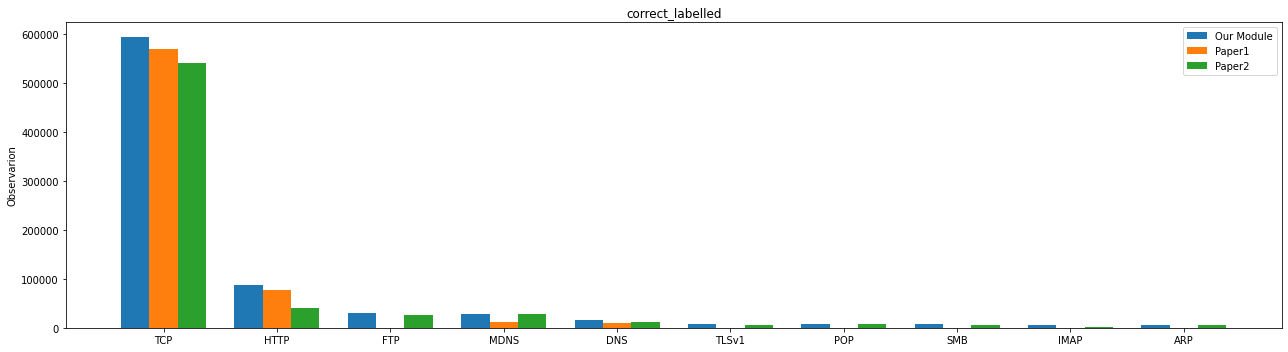

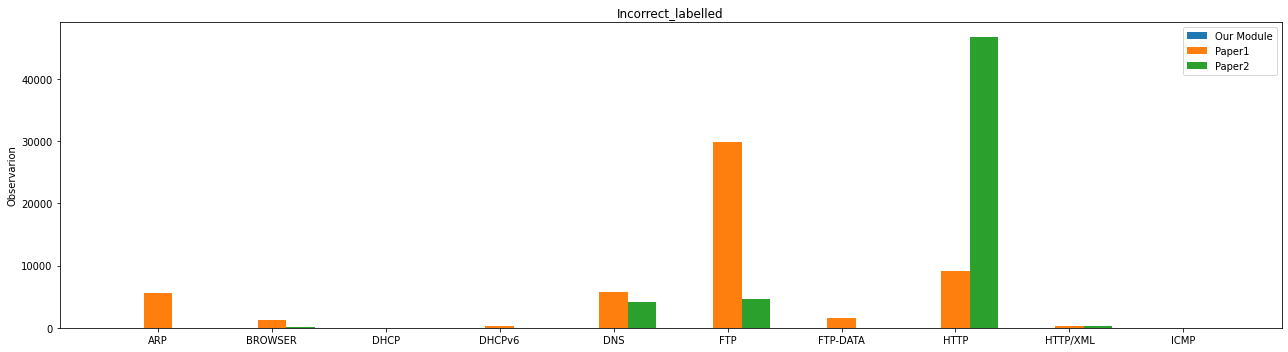

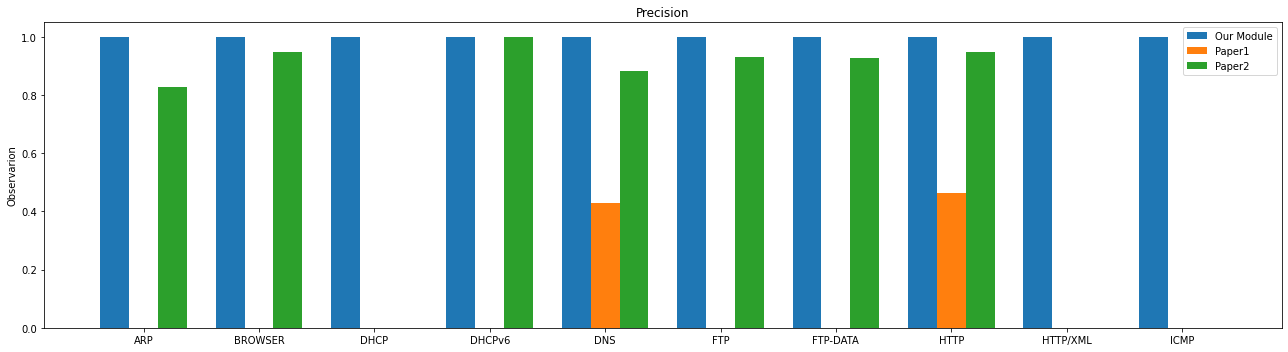

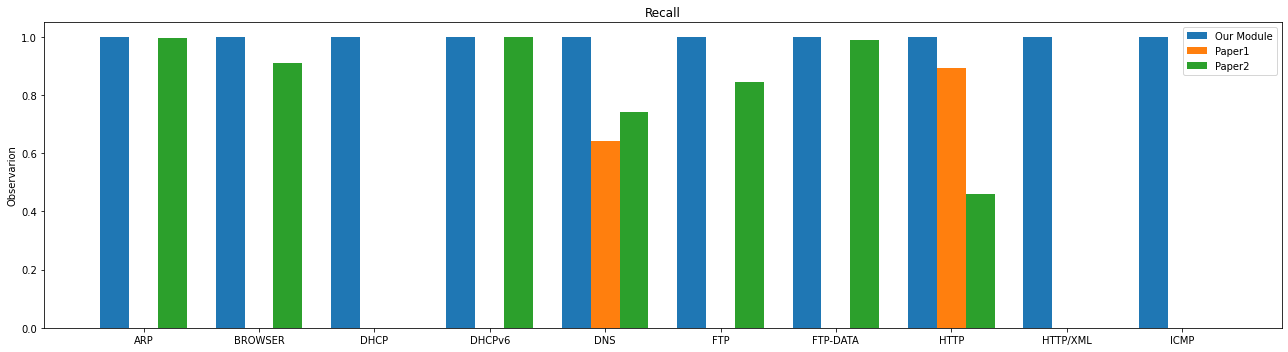

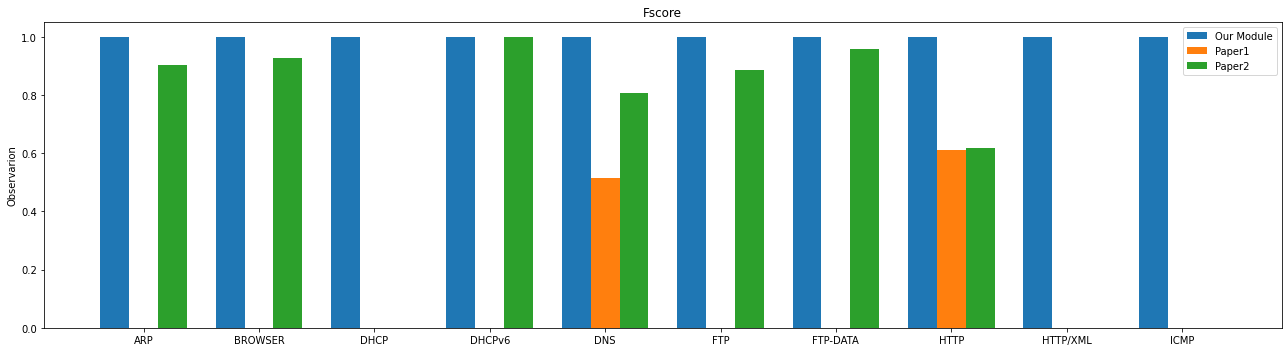

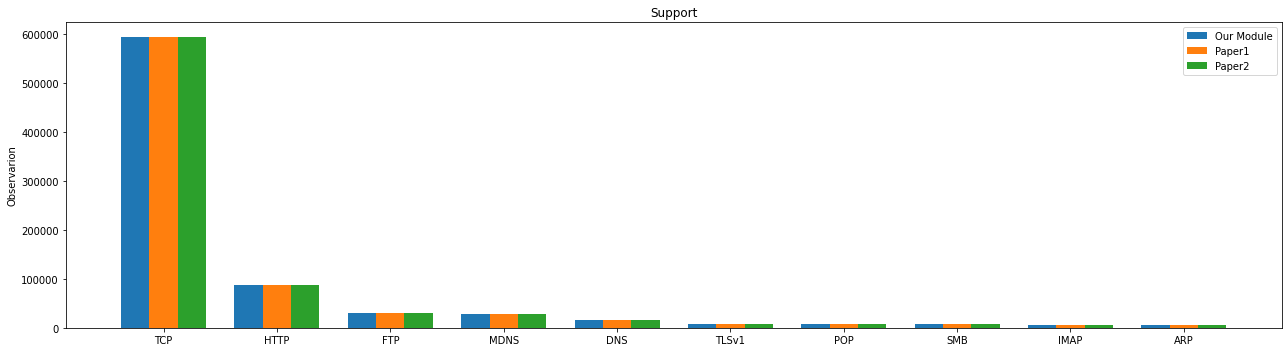

In [12]:
## Plotting Training results:

#correct_labelled
plotBased(results1.iloc[:,1], results2.iloc[:,1], results3.iloc[:,1], 'correct_labelled', label_names_training)

#Incorrect_labelled
plotBased(results1.iloc[:,2], results2.iloc[:,2], results3.iloc[:,2], 'Incorrect_labelled', label_names_training)

#Precision
plotBased(resultsDataFrame1.iloc[0,1:], resultsDataFrame2.iloc[0,1:], resultsDataFrame3.iloc[0,1:], 'Precision', label_names_training)

#Recall
plotBased(resultsDataFrame1.iloc[1,1:], resultsDataFrame2.iloc[1,1:], resultsDataFrame3.iloc[1,1:], 'Recall', label_names_training)

#Fscore
plotBased(resultsDataFrame1.iloc[2,1:], resultsDataFrame2.iloc[2,1:], resultsDataFrame3.iloc[2,1:], 'Fscore', label_names_training)

#Support
plotBased(resultsDataFrame1.iloc[3,1:], resultsDataFrame2.iloc[3,1:], resultsDataFrame3.iloc[3,1:], 'Support', label_names_training)

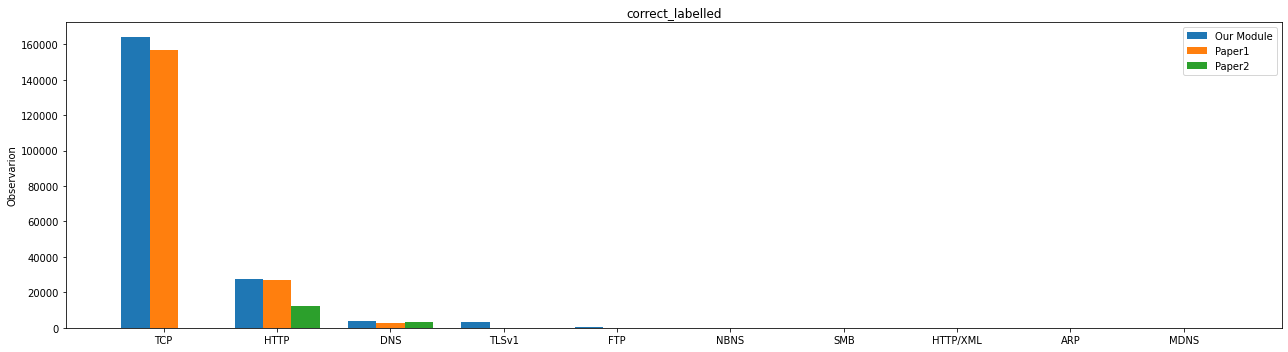

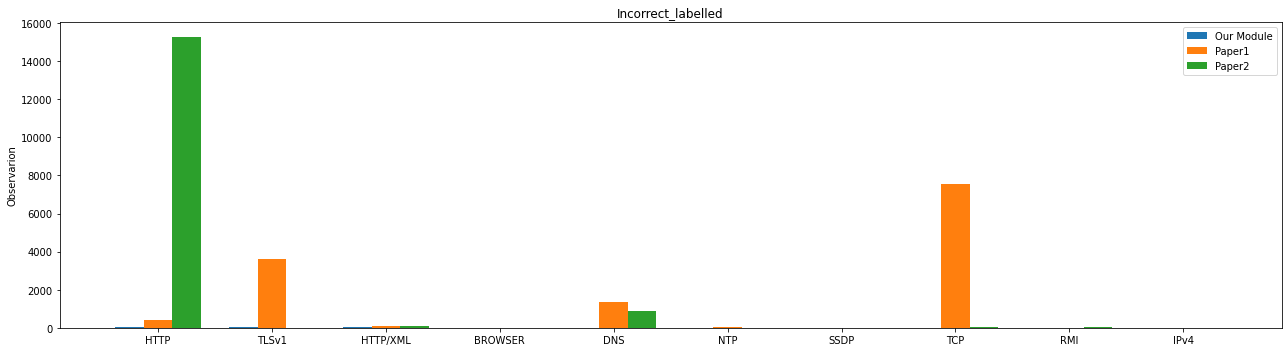

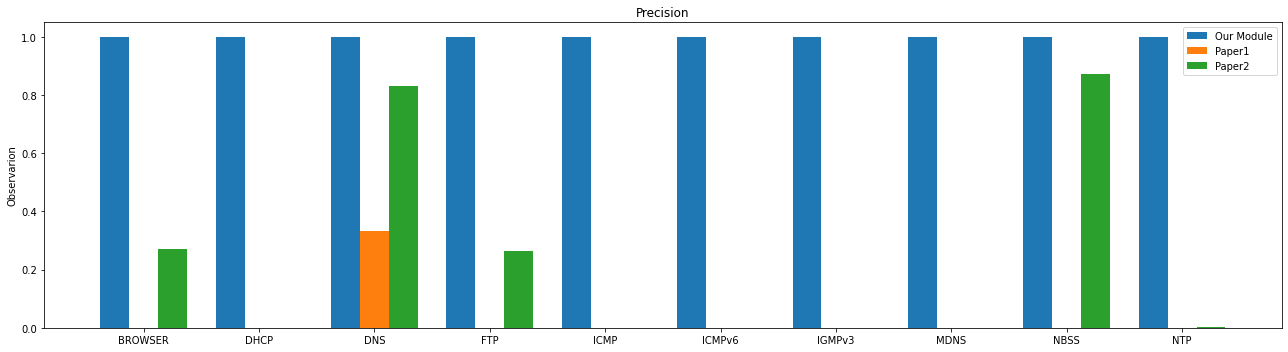

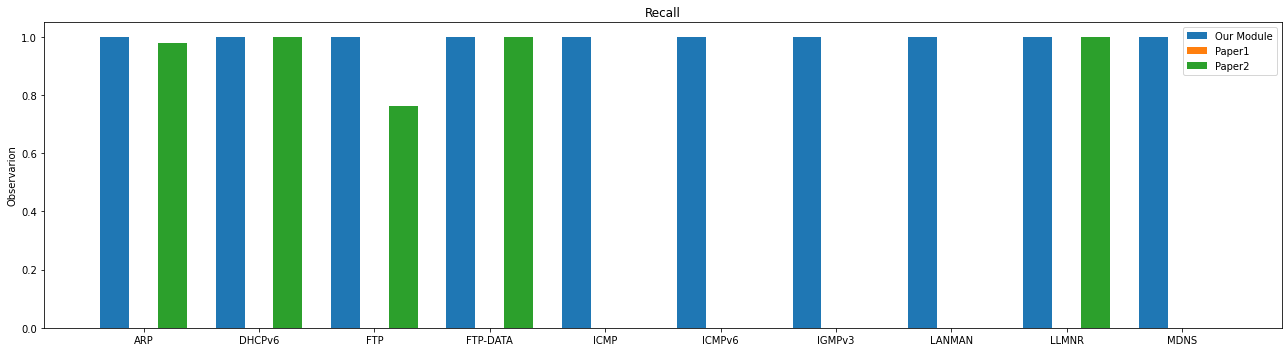

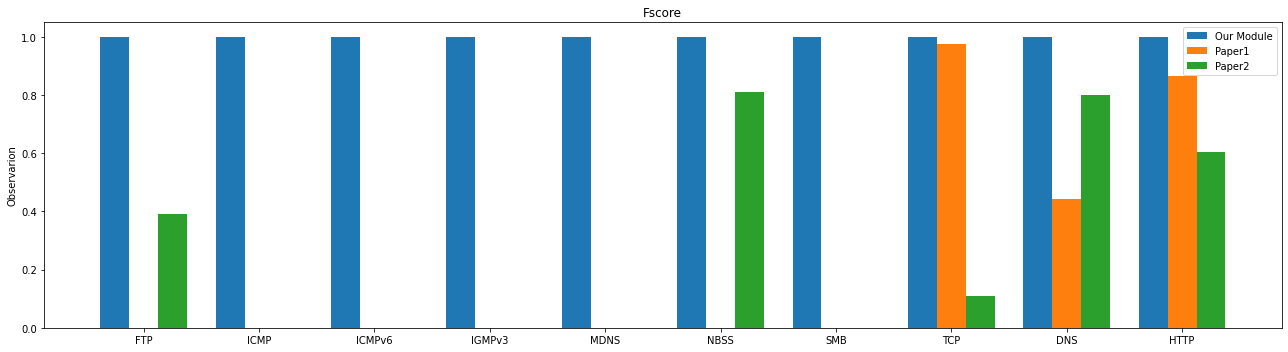

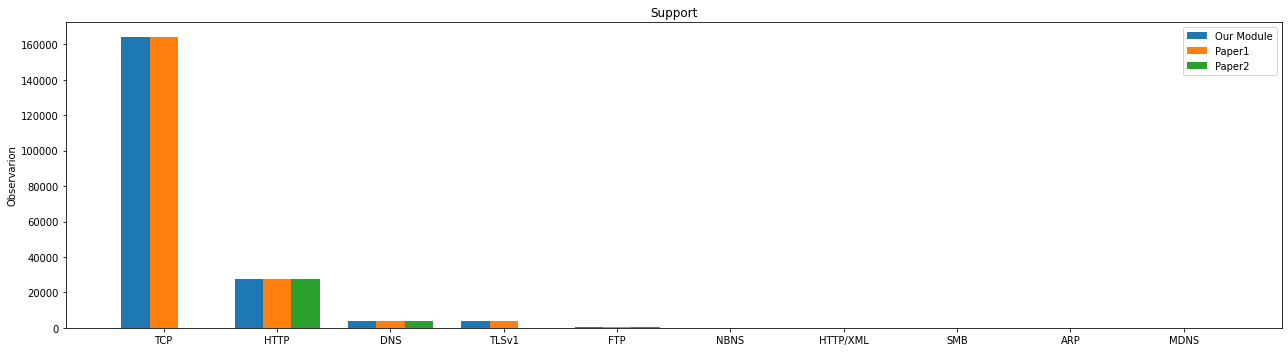

In [13]:
## Plotting Testing results:

#correct_labelled
plotBased(results1Test.iloc[:,1], results2Test.iloc[:,1], results3Test.iloc[:,1], 'correct_labelled', label_names_testing)

#Incorrect_labelled
plotBased(results1Test.iloc[:,2], results2Test.iloc[:,2], results3Test.iloc[:,2], 'Incorrect_labelled', label_names_testing)

#Precision
plotBased(resultsDataFrame1Test.iloc[0,1:], resultsDataFrame2Test.iloc[0,1:], resultsDataFrame3Test.iloc[0,1:], 'Precision', label_names_testing)

#Recall
plotBased(resultsDataFrame1Test.iloc[1,1:], resultsDataFrame2Test.iloc[1,1:], resultsDataFrame3Test.iloc[1,1:], 'Recall', label_names_testing)

#Fscore
plotBased(resultsDataFrame1Test.iloc[2,1:], resultsDataFrame2Test.iloc[2,1:], resultsDataFrame3Test.iloc[2,1:], 'Fscore', label_names_testing)

#Support
plotBased(resultsDataFrame1Test.iloc[3,1:], resultsDataFrame2Test.iloc[3,1:], resultsDataFrame3Test.iloc[3,1:], 'Support', label_names_testing)

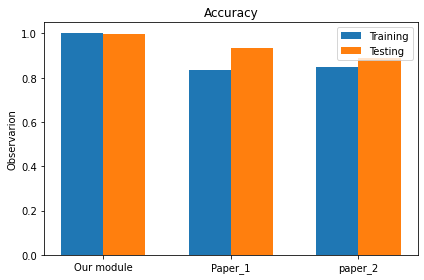

In [14]:
labels = ['Our module', 'Paper_1', 'paper_2']

x = np.arange(len(labels))  # the label locations
width = 0.33  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [ourModelTrainingAcc,Paper1TrainingAcc,Paper2TrainingAcc], width, label='Training')
rects2 = ax.bar(x + width/2, [ourModelTestingAcc,Paper1TestingAcc,Paper2TestingAcc], width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Observarion')
ax.set_title('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(array1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()